In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from pathlib import Path
import cv2
import glob
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as process_mobileNetV3Large
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as process_efficientNetV2B0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

train_path = '/content/drive/MyDrive/PaddyDisease/balanced_oversampling'
test_path  = '/content/drive/MyDrive/PaddyDisease/test_data'
IMG_SHAPE = (224, 224, 3)
batch_size = 32
classData = 10

In [ ]:
#data awal setelah dipisah secara manual. Data yang lebih dari 1000, telah dipisah secara manual
print('Dataset Training UnderSampling Balanced')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


print('Dataset Testing UnderSampling Balanced')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

Dataset Training UnderSampling Balanced
1000 	 tungro
1000 	 bacterial_panicle_blight
1000 	 bacterial_leaf_streak
1000 	 downy_mildew
1000 	 brown_spot
1000 	 bacterial_leaf_blight
1000 	 hispa
1000 	 dead_heart
1000 	 blast
1000 	 normal
Dataset Testing UnderSampling Balanced
100 	 brown_spot
100 	 normal
100 	 downy_mildew
100 	 tungro
100 	 bacterial_leaf_streak
100 	 dead_heart
100 	 hispa
100 	 blast
100 	 bacterial_panicle_blight
100 	 bacterial_leaf_blight


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(224,224),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=1
)

Found 10000 files belonging to 10 classes.
Using 9000 files for training.
Found 10000 files belonging to 10 classes.
Using 1000 files for validation.
Found 1000 files belonging to 10 classes.


In [ ]:
#Ensemble Model Using Concatenation Method

model_MobileNetV3Large = MobileNetV3Large(
    include_top=False,
    alpha=1.0,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model_EfficientNetV2B0 = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

for layer in model_MobileNetV3Large.layers:
        layer.trainable = False


for layer in model_EfficientNetV2B0.layers:
        layer.trainable = False

models = [model_MobileNetV3Large, model_EfficientNetV2B0]
print(models)

24274472/24274472 [==============================] - 0s 0us/step
[<keras.engine.functional.Functional object at 0x7f2c94133d30>, <keras.engine.functional.Functional object at 0x7f2c06630c70>]


In [ ]:
inp = Input((224,224,3))

mobileNetV3Large_process = Lambda(process_mobileNetV3Large)(inp)
MobileNetV3Large = model_MobileNetV3Large(mobileNetV3Large_process)

efficientNetV2B0_process = Lambda(process_efficientNetV2B0)(inp)
EfficientNetV2B0 = model_EfficientNetV2B0(efficientNetV2B0_process)

x = Concatenate()([MobileNetV3Large, EfficientNetV2B0])
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(10, activation='softmax')(x) 

concatenation_ensemble_model = Model(inp, out)
concatenation_ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])  

In [ ]:
#custom callback
class_names = train_ds.class_names
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = concatenation_ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
282/282 [==============================] - 960s 3s/step - loss: 1.0538 - accuracy: 0.7161 - val_loss: 0.4434 - val_accuracy: 0.8790
Epoch 2/10
282/282 [==============================] - 41s 142ms/step - loss: 0.1594 - accuracy: 0.9516 - val_loss: 0.3125 - val_accuracy: 0.9120
Epoch 3/10
282/282 [==============================] - 41s 144ms/step - loss: 0.0794 - accuracy: 0.9780 - val_loss: 0.3709 - val_accuracy: 0.9030
Epoch 4/10
282/282 [==============================] - 42s 145ms/step - loss: 0.0588 - accuracy: 0.9860 - val_loss: 0.4247 - val_accuracy: 0.9110
Epoch 5/10
282/282 [==============================] - 41s 144ms/step - loss: 0.0569 - accuracy: 0.9864 - val_loss: 0.4047 - val_accuracy: 0.9100


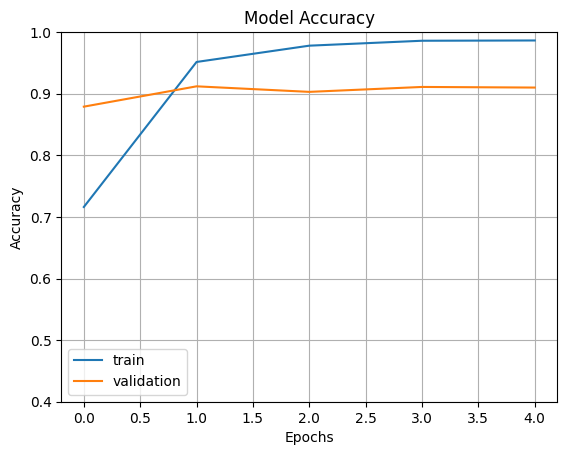

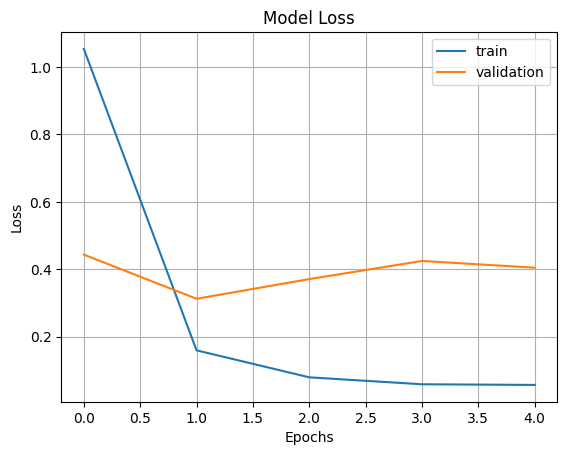

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

#predict
predictions = concatenation_ensemble_model.predict(test_ds)

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names, digits=4))

1000/1000 [==============================] - 27s 27ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.8911    0.9000    0.8955       100
   bacterial_leaf_streak     0.9785    0.9100    0.9430       100
bacterial_panicle_blight     0.9223    0.9500    0.9360       100
                   blast     0.9072    0.8800    0.8934       100
              brown_spot     0.8911    0.9000    0.8955       100
              dead_heart     0.9691    0.9400    0.9543       100
            downy_mildew     0.9000    0.9000    0.9000       100
                   hispa     0.8942    0.9300    0.9118       100
                  normal     0.8824    0.9000    0.8911       100
                  tungro     0.9118    0.9300    0.9208       100

                accuracy                         0.9140      1000
               macro avg     0.9148    0.9140    0.9141      1000
            weighted avg     0.9148    0.9140    0.9141      1000



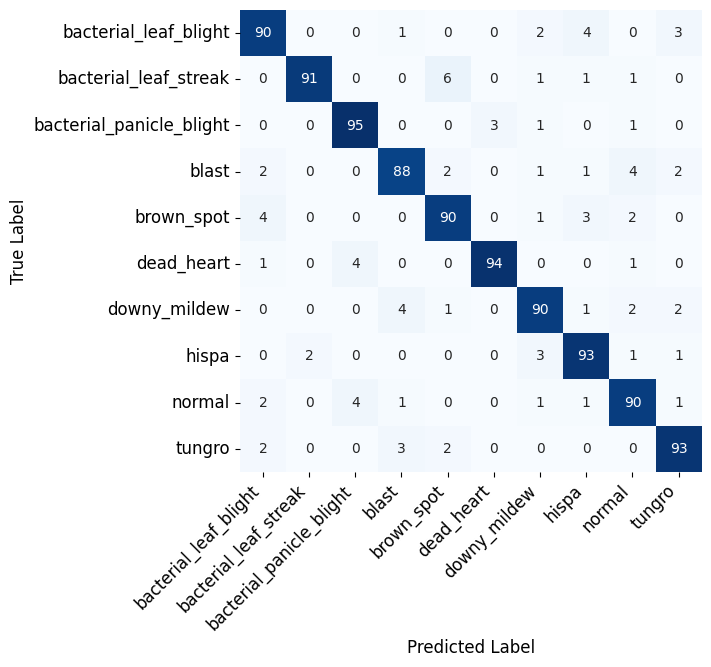

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="ConcatenationEnsemble-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
concatenation_ensemble_model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EnsembleConcatenation_OverSampling_224_2.h5')